# Analysis: XGBoost for Profitability

Goal: Use XGBoost to create a model classifying the profitable feature.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

Using TensorFlow backend.



Confusion matrix

Example of confusion matrix usage to evaluate the quality
of the output of a classifier on the iris data set. The
diagonal elements represent the number of points for which
the predicted label is equal to the true label, while
off-diagonal elements are those that are mislabeled by the
classifier. The higher the diagonal values of the confusion
matrix the better, indicating many correct predictions.

The figures show the confusion matrix with and without
normalization by class support size (number of elements
in each class). This kind of normalization can be
interesting in case of class imbalance to have a more
visual interpretation of which class is being misclassified.

Here the results are not as good as they could be as our
choice for the regularization parameter C was not the best.
In real life applications this parameter is usually chosen
using :ref:`grid_search`.


Confusion matrix, without normalization
[[13  0  0]
 [ 0 10  6]
 [ 0  0  9]]
Normalized confusion

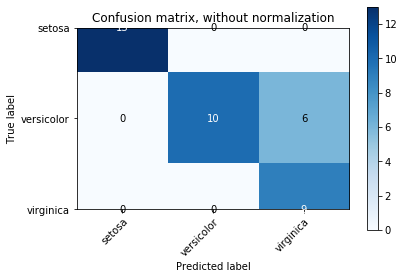

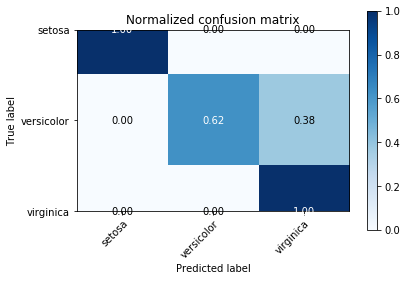

In [2]:
import sys
sys.path.append('../')
import plot_confusion_matrix as pcm;

In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

## Prepare Target & Features

In [4]:
FEATURE_FILE = '../data/merge_feature.csv'
full_df = pd.read_csv(FEATURE_FILE)

In [5]:
# drop volume and weight since they are sparse and colinear,
# drop arbitrary details set_no, name,
# drop price data used to create the target,
# drop popularity because it reflects future perception not time of purchase info.

full_df.drop(columns=['set_no', 'name',  'price_store', 'price_used',
                      'volume', 'weight', 'number_parts', 'total_parts',
                      'popularity', 'aftermarket', 'adj_store_price',
                      'adj_aftermarket'], inplace=True)

# filter out rows without profitable (i.e. target), and the few without primary/secondary colors
full_df.dropna(axis=0,
               subset=['profitable', 'scolor_1st', 'scolor_2nd'],
               inplace=True)

full_df.head()
full_df.info(verbose=True, null_counts=True)

,year,number_spare_parts,total_spare_parts,number_colors,bars_ladders_and_fences_cnt_prts,baseplates_cnt_prts,belville_scala_and_fabuland_cnt_prts,bionicle_hero_factory_and_constraction_cnt_prts,bricks_cnt_prts,bricks_curved_cnt_prts,...,transportation_-_sea_and_air_tot_prts,tubes_and_hoses_tot_prts,wheels_and_tyres_tot_prts,windows_and_doors_tot_prts,windscreens_and_fuselage_tot_prts,znap_tot_prts,category,scolor_1st,scolor_2nd,profitable
4,1984,0,0,7,1,1,3,0,6,2,...,0,0,0,3,0,0,Bigfig-Junior,Yellow,Red,1.0
5,1984,2,2,8,1,1,3,0,2,0,...,3,0,0,7,0,0,Bigfig-Junior,Yellow,Red,1.0
8,1984,0,0,8,0,0,0,0,1,0,...,0,0,2,0,0,0,Historical,Black,Red,1.0
9,1984,4,4,8,0,0,0,0,2,0,...,0,0,0,0,0,0,Historical,Black,Blue,1.0
10,1984,0,0,7,0,0,0,0,3,0,...,0,0,2,0,0,0,Historical,Black,Red,1.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3824 entries, 4 to 4921
Data columns (total 122 columns):
year                                                3824 non-null int64
number_spare_parts                                  3824 non-null int64
total_spare_parts                                   3824 non-null int64
number_colors                                       3824 non-null int64
bars_ladders_and_fences_cnt_prts                    3824 non-null int64
baseplates_cnt_prts                                 3824 non-null int64
belville_scala_and_fabuland_cnt_prts                3824 non-null int64
bionicle_hero_factory_and_constraction_cnt_prts     3824 non-null int64
bricks_cnt_prts                                     3824 non-null int64
bricks_curved_cnt_prts                              3824 non-null int64
bricks_printed_cnt_prts                             3824 non-null int64
bricks_round_and_cones_cnt_prts                     3824 non-null int64
bricks_sloped_cnt_prts      

In [6]:
# target series
target = full_df['profitable']
print(target.shape)

# initial features
features = full_df.drop(columns=['profitable'])
print(features.shape)

(3824,)
(3824, 121)


In [7]:
# feature dataframe with one-hot encoding

features = pd.get_dummies(features, drop_first= True,
                          columns=['category', 'scolor_1st', 'scolor_2nd'])
features.shape

(3824, 149)

## Train-Test Split & Standardize

In [8]:
TEST_SPLIT = 0.2
SEED = 0

In [9]:
y_train, y_test, X_train, X_test = train_test_split(target, features,
                                                    stratify=features['year'],
                                                    test_size=TEST_SPLIT, random_state=SEED)

y_train.shape
y_test.shape 
X_train.shape
X_test.shape

(3059,)

(765,)

(3059, 149)

(765, 149)

In [10]:
std_scaler = StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

## PCA Analysis

In [11]:
# Initial full PCA of features
pca = PCA()
x_pca = pca.fit_transform(X_train_std)

In [12]:
# exploring explained variance
len(pca.explained_variance_ratio_)

149

In [13]:
# defining count of PCA features to capture 99% of variance
PCA_COUNT = sum(pca.explained_variance_ratio_.cumsum() < .95) + 1
PCA_COUNT
PCA_EXPLAINED_VAR = pca.explained_variance_ratio_.cumsum()[PCA_COUNT-1]
PCA_EXPLAINED_VAR

81

0.951714458249764

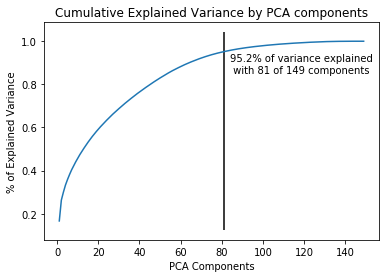

In [14]:
# plotting PCA cumulative explained variance.
# plenty of dimension reduction will be possible,
# which will allow the model to perform more quickly,
# particularlly during GridSearchCV
plt.plot(range(1,150), pca.explained_variance_ratio_.cumsum())

ax = plt.gca()
ax.set_xlabel("PCA Components")
ax.set_ylabel("% of Explained Variance")
ax.set_title("Cumulative Explained Variance by PCA components")

ax.vlines(x=PCA_COUNT, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1])
ax.annotate(f'{round(100*PCA_EXPLAINED_VAR,1)}% of variance explained \n with {PCA_COUNT} of 149 components',
            xy=[PCA_COUNT, PCA_EXPLAINED_VAR],
            xytext=[PCA_COUNT+3, PCA_EXPLAINED_VAR-0.1]);

In [15]:
final_pca = PCA(n_components=PCA_COUNT)
X_train_pca = final_pca.fit_transform(X_train_std)
X_test_pca = final_pca.transform(X_test_std)

In [25]:
len(y_train[y_train==0]) / len(y_train)

0.7378228179143511

In [16]:
y_train.value_counts()
len(y_test==0) / len(y_test)

0.0    2257
1.0     802
Name: profitable, dtype: int64

2.814214463840399

## GridSearchCV with XGBoost

In [29]:
class_pos_rate = y_train.value_counts()[0] / y_train.value_counts()[1]
param_grid1 = {"learning_rate": [0.1, 0.2],
               'max_depth': [3, 6, 9],
               'min_child_weight': [1, 3],
               'subsample': [0.6, 0.75, 1],
               'n_estimators': [100, 150, 200]}
clf = XGBClassifier(scale_pos_weight=class_pos_rate)
grid_clf = GridSearchCV(clf, param_grid1, scoring='accuracy', cv=3)

In [30]:
grid_clf.fit(X_train_pca, y_train);

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=2.814214463840399,
                                     seed=None, silent=None, subsample=1,
                                     verbosity=1),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.4, 0.7],
                         'max_depth': [3, 6, 9], 'min_c

In [31]:
grid_clf_results = pd.DataFrame(grid_clf.cv_results_)

In [32]:
grid_clf_results.mean_test_score.describe()

count    243.000000
mean       0.747251
std        0.016167
min        0.693037
25%        0.735371
50%        0.748938
75%        0.759889
max        0.776724
Name: mean_test_score, dtype: float64

In [33]:
best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train_pca)
training_accuracy = accuracy_score(y_train, training_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))

val_preds = grid_clf.predict(X_test_pca)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Validation Accuracy: {:.4}%".format(val_accuracy * 100))
print("")
print("Random Guess Accuracy: {:.4}%".format(len(y_test[y_test==0]) / len(y_test) * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 150
subsample: 0.75

Training Accuracy: 99.77%


In [ ]:
#plotting confusion matrix
pcm.plot_confusion_matrix(y_test.astype('int64'),
                          val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost after PCA",
                          classes=np.array([0,1]))

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
plt.gca().set_ylim(1.5, -0.5);

## GridSearchCV with XGBoost and SMOTE Oversampling

In [18]:
smote_pipe = Pipeline([("SMOTE", SMOTE()),
                       ("xgb", XGBClassifier())])

param_grid2 = {"xgb__learning_rate": [0.1, 0.2],
               'xgb__max_depth': [3, 6, 9],
               'xgb__min_child_weight': [1, 3],
               'xgb__subsample': [0.6, 0.75, 1],
               'xgb__n_estimators': [100, 150, 200]}
smote_grid_clf = GridSearchCV(smote_pipe, param_grid2, scoring='accuracy', cv=3)

In [19]:
smote_grid_clf.fit(X_train_pca, y_train);

In [20]:
smote_grid_clf_results = pd.DataFrame(smote_grid_clf.cv_results_)

In [21]:
smote_grid_clf_results.mean_test_score.describe()

count    243.000000
mean       0.736546
std        0.015428
min        0.687806
25%        0.726872
50%        0.738150
75%        0.748774
max        0.766263
Name: mean_test_score, dtype: float64

In [24]:
smote_best_parameters = smote_grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(smote_best_parameters.keys()):
    print("%s: %r" % (param_name, smote_best_parameters[param_name]))

smote_training_preds = smote_grid_clf.predict(X_train_pca)
smote_training_accuracy = accuracy_score(y_train, smote_training_preds)

print("")
print("Training Accuracy: {:.4}%".format(smote_training_accuracy * 100))

smote_val_preds = smote_grid_clf.predict(X_test_pca)
smote_val_accuracy = accuracy_score(y_test, smote_val_preds)

print("")
print("Validation Accuracy: {:.4}%".format(smote_val_accuracy * 100))
print("")
print("Random Guess Accuracy: {:.4}%".format(len(y_test[y_test==0]) / len(y_test) * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.1
xgb__max_depth: 9
xgb__min_child_weight: 1
xgb__n_estimators: 150
xgb__subsample: 0.75

Training Accuracy: 99.77%

Validation Accuracy: 78.43%


Confusion matrix, without normalization
[[488  64]
 [101 112]]


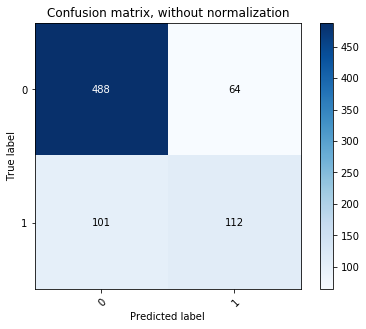

In [56]:
#plotting confusion matrix
pcm.plot_confusion_matrix(y_test.astype('int64'),
                          smote_val_preds.astype('int64'),
                          title="Confusion Matrix - SMOTE & XGBoost after PCA",
                          classes=np.array([0,1]))

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
plt.gca().set_ylim(1.5, -0.5);

## GrideSearchCV with XGBoost and a full Process Pipeline

In [60]:
full_process_pipe = Pipeline([("scaler", StandardScaler()),
                              ("pca", PCA(n_components=PCA_COUNT)),
                              ("smote", SMOTE()),
                              ("xgb", XGBClassifier())])

param_grid2 = {"xgb__learning_rate": [0.1, 0.2],
               'xgb__max_depth': [3, 6, 9],
               'xgb__min_child_weight': [1, 3],
               'xgb__subsample': [0.6, 0.75, 1],
               'xgb__n_estimators': [100, 150, 200]}
full_grid_clf = GridSearchCV(full_process_pipe, param_grid2, scoring='accuracy', cv=3)

In [ ]:
full_grid_clf.fit(X_train, y_train);

In [20]:
full_grid_clf_results = pd.DataFrame(full_grid_clf.cv_results_)

In [21]:
full_grid_clf_results.mean_test_score.describe()

count    243.000000
mean       0.736546
std        0.015428
min        0.687806
25%        0.726872
50%        0.738150
75%        0.748774
max        0.766263
Name: mean_test_score, dtype: float64

In [22]:
full_best_parameters = full_grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(full_best_parameters.keys()):
    print("%s: %r" % (param_name, full_best_parameters[param_name]))

full_training_preds = full_grid_clf.predict(X_train)
full_training_accuracy = accuracy_score(y_train, training_preds)

print("")
print("Training Accuracy: {:.4}%".format(full_training_accuracy * 100))

full_val_preds = full_grid_clf.predict(X_test)
full_val_accuracy = accuracy_score(y_test, full_val_preds)

print("")
print("Validation Accuracy: {:.4}%".format(full_val_accuracy * 100))
print("")
print("Random Guess Accuracy: {:.4}%".format(len(y_test[y_test==0]) / len(y_test) * 100))

Grid Search found the following optimal parameters: 
xgb__learning_rate: 0.1
xgb__max_depth: 9
xgb__min_child_weight: 1
xgb__n_estimators: 150
xgb__subsample: 0.75

Training Accuracy: 99.77%


In [ ]:
#plotting confusion matrix
pcm.plot_confusion_matrix(y_test.astype('int64'),
                          full_val_preds.astype('int64'),
                          title="Confusion Matrix - XGBoost with integrate PCA & SMOTE",
                          classes=np.array([0,1]))

# a bug in the current version of matplotlib shifts the default ylim,
# and the code below corrects it
plt.gca().set_ylim(1.5, -0.5);

## Testing